In [1]:
# Data manipulation 
import numpy as np
import pandas as pd
import math

# Visualization
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
from sklearn.decomposition import PCA

import KPI

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

# Models
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')


In [2]:
data = pd.read_csv('raw_data_sensor.csv', sep = ',', decimal = '.')
# data = pd.read_csv('data_measurement.csv')

# data = data[['Hour', 'SpaceName', 'PortName', 'Value']]
data = data[['Datetime', 'Date', 'Time', 'SpaceName', 'SpaceSubType', 'DeviceVendor', 'DeviceName', 'PortName', 'Value']]
data.head()

,Datetime,Date,Time,SpaceName,SpaceSubType,DeviceVendor,DeviceName,PortName,Value
0,2019-10-01 02:00:00,2019-10-01,02:00:00,B4 Hallway,Hallway Area,bGrid,Unilever-bGrid-2992,Temperature,22.19
1,2019-10-01 02:00:00,2019-10-01,02:00:00,A4 Hallway,Hallway Area,bGrid,Unilever-bGrid-2515,Temperature,23.90
2,2019-10-01 02:00:00,2019-10-01,02:00:00,A4 Hallway,Hallway Area,bGrid,Unilever-bGrid-2578,Temperature,23.19
3,2019-10-01 02:00:00,2019-10-01,02:00:00,B4 Hallway,Hallway Area,bGrid,Unilever-bGrid-2986,Temperature,22.07
4,2019-10-01 02:00:00,2019-10-01,02:00:00,B4 Hallway,Hallway Area,bGrid,Unilever-bGrid-2990,Temperature,23.10


In [3]:
measurements = data['PortName'].unique()
measurements

array(['Temperature', 'Humidity', 'Light', 'Motion', 'Sound', 'PM25',
       'TVOC', 'PM10', 'Occupancy', 'CarbonDioxide', 'Volume',
       'EnergyConsumption'], dtype=object)

In [4]:
# Function to get the measurements as seperate arrays - left for later

def get_single_measurement(data, measurement = str):

    measurement_name = data.loc[data['PortName'] == f'{measurement}', ['Datetime', 'SpaceName', 'DeviceName', 'PortName', 'Value']].pivot_table(index = 'Datetime', columns = ['DeviceName'], values = ['Value'])
    measurement_name = measurement_name.fillna(0)
    return measurement_name

Temperature = get_single_measurement(data, 'Temperature')
Humidity = get_single_measurement(data, 'Humidity')
Light = get_single_measurement(data, 'Light')
Noise = get_single_measurement(data, 'Sound')
Occupancy = get_single_measurement(data, 'Occupancy')
Movement = get_single_measurement(data, 'Motion')
CO2 = get_single_measurement(data, 'CarbonDioxide')
Energy = get_single_measurement(data, 'EnergyConsumption')
Water = get_single_measurement(data, 'Volume')

In [6]:
Temperature
Temperature.to_csv('pivot.csv')

In [ ]:
# Light = np.log(Light)

# sns.distplot(Light,kde=True) 

In [ ]:
missingno.matrix(Temperature, figsize = (30,10))

In [ ]:
# normalise data - remove scale effect
measure = Temperature
centered_data = measure - np.mean(measure)

normalised_data = StandardScaler().fit_transform(centered_data)
# normalised_data = preprocessing.normalize(centered_data)
# normalised_data = centered_data
n_PC = 10
# pca = PCA(n_components = k)

model = PCA(n_components = n_PC).fit(normalised_data)
PCA_fit = model.transform(normalised_data)

# PCA_fit = pca.fit_transform(normalised_data)

# In case want to remove a column before and add it after PCA
# PCA_final = pd.concat([PCA, measure[['SpaceName']]])

In [ ]:
fig = plt.figure(figsize=(8, 6))

ax = fig.add_subplot(1,1,1)

plt.plot(model.explained_variance_ratio_, '--o', label = 'Explained variance ratio')
plt.plot(model.explained_variance_ratio_.cumsum(), '--o', label = 'Cumulative explained variance ratio');

# ax.yaxis.set_major_formatter(PercentFormatter())

plt.yticks(np.arange(min(model.explained_variance_ratio_), max(model.explained_variance_ratio_) + 0.7, 0.1))
plt.legend()

In [ ]:
n = len(normalised_data)

cov = np.matmul(normalised_data.T, normalised_data)/n

u, s, v = np.linalg.svd(cov)

k = 10

eigenvectors = u[:, 0:k]
eigenvalues = s[0:k]

scores = np.matmul(normalised_data, eigenvectors)

#projection of data onto k dimensional space
projection_of_data = np.matmul(scores, eigenvectors.T)

#projection onto residual space
projection_residual = np.matmul(normalised_data, (np.diag(np.ones(len(eigenvectors))) - np.matmul(eigenvectors, eigenvectors.T)))

Q = []
T2 = []
SPE = []

for row in range(len(projection_residual)):

    q = np.matmul(projection_residual[row], projection_residual[row].T)
    t = np.matmul(np.matmul(scores[row], np.linalg.inv(np.diag(eigenvalues))), scores[row].T)
    spe = np.linalg.norm(projection_residual[row])
    
    Q.append(q)
    T2.append(t)
    SPE.append(spe)


In [181]:
confidence = 0.95
from scipy.stats import sem, t
from scipy import mean

n = len(normalised_data)

m = mean(Q)
std_err = sem(Q)
h = std_err * t.ppf((1 + confidence) / 2, k - 1)

conf_level_Q = (m + h) * np.ones(n)

from scipy.stats import chi2
# confidence level
p = 0.95
# chi2 value
# number of degrees of freedom is the number of k-most important PCs
valueChi2 = chi2.ppf(p, k)

conf_level_Chi = np.ones(n) * valueChi2


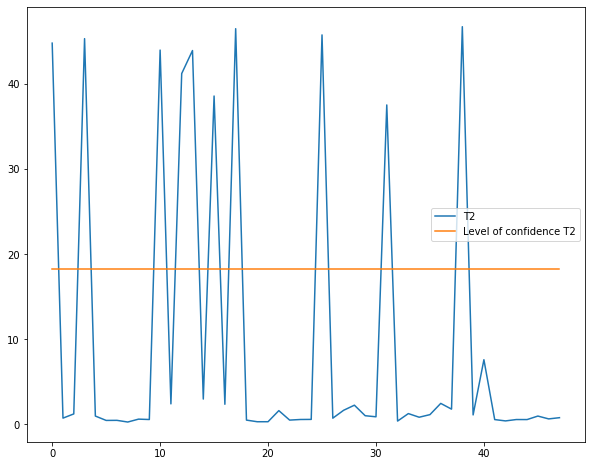

In [182]:
fig = plt.figure(figsize=(10, 8))

# plt.plot(Q, label = 'Q')
plt.plot(T2, label = 'T2')
# plt.plot(SPE, label = 'SPE')
# plt.plot(normalised_data[:, 0], label = 'CO2')

plt.plot(conf_level_Chi, label = 'Level of confidence T2')
# plt.plot(conf_level_Q, label = 'Level of confidence Q')

plt.legend()
plt.show()


In [184]:
anomaly = np.where(T2 > conf_level_Chi)


mapping = pd.read_csv('mapping.csv', sep=',', decimal='.')

# measure = measure.join(mapping.set_index('DeviceName'), on = 'DeviceName')

data_anomaly = measure.ix[anomaly]


data_anomaly

Value                            \
DeviceName          OLY-Awair-awair-omni_7663 OLY-Awair-awair-omni_7671   
Datetime                                                                  
2019-10-01 00:00:00                 21.602500                    23.668   
2019-10-01 03:00:00                 21.620000                    23.698   
2019-10-01 10:00:00                 22.307500                    24.405   
2019-10-01 12:00:00                 22.256667                    25.070   
2019-10-01 13:00:00                 22.085000                    25.370   
2019-10-01 15:00:00                 22.130000                    24.330   
2019-10-01 17:00:00                 22.170000                     0.000   
2019-10-02 01:00:00                 21.758000                    23.655   
2019-10-02 07:00:00                 21.005000                    23.010   
2019-10-02 14:00:00                 21.456667                    24.505   

                                                                         \
DeviceName          OLY-Awair-awair-omni_7794 OLY-Awair-awair-omni_7848   
Datetime                                                                  
2019-10-01 00:00:00                  0.000000                  0.000000   
2019-10-01 03:00:00                 21.823333                  0.000000   
2019-10-01 10:00:00                 22.690000                  0.000000   
2019-10-01 12:00:00                 22.860000                  0.000000   
2019-10-01 13:00:00                 23.060000                  0.000000   
2019-10-01 15:00:00                 22.820000                  0.000000   
2019-10-01 17:00:00                 22.720000                  0.000000   
2019-10-02 01:00:00                 22.345000                  0.000000   
2019-10-02 07:00:00                 22.316667                  0.000000   
2019-10-02 14:00:00                 22.833333                 23.863333   

                                                                         \
DeviceName          OLY-Awair-awair-omni_7884 OLY-Awair-awair-omni_8659   
Datetime                                                                  
2019-10-01 00:00:00                 21.800000                 22.645000   
2019-10-01 03:00:00                 21.740000                 22.733333   
2019-10-01 10:00:00                 21.710000                 22.850000   
2019-10-01 12:00:00                 21.900000                 23.825000   
2019-10-01 13:00:00                 22.113333                 23.623333   
2019-10-01 15:00:00                  0.000000                 23.320000   
2019-10-01 17:00:00                 22.376667                 23.290000   
2019-10-02 01:00:00                 22.080000                 22.710000   
2019-10-02 07:00:00                  0.000000                  0.000000   
2019-10-02 14:00:00                 21.670000                 22.446667   

                                                                         \
DeviceName          OLY-Awair-awair-omni_8791 OLY-Awair-awair-omni_8831   
Datetime                                                                  
2019-10-01 00:00:00                 21.310000                 22.085000   
2019-10-01 03:00:00                 21.153333                 22.255000   
2019-10-01 10:00:00                 22.977500                 23.250000   
2019-10-01 12:00:00                 22.526667                 23.500000   
2019-10-01 13:00:00                 22.791667                 23.594000   
2019-10-01 15:00:00                 23.032500                 23.005000   
2019-10-01 17:00:00                 22.391667                 22.145000   
2019-10-02 01:00:00                 21.432500                  0.000000   
2019-10-02 07:00:00                 21.955000                 22.286667   
2019-10-02 14:00:00                 22.935000                 22.806667   

                                                                         ...  \
DeviceName          OLY-Awair-awair-omni_8937 OLY-Awair-